In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import os
from torch.utils.data import DataLoader,Dataset
import scipy
from PIL import Image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

In [6]:
class OxfordCustomDataset(Dataset):
    def __init__(self, img_dir, label_file, split_file, transform, split='train'):
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform


        labels = scipy.io.loadmat(label_file)['labels'][0]
        self.labels = labels - 1

        setid = scipy.io.loadmat(split_file)
        if split == 'train':
            self.indices = setid['tstid'][0]
        elif split == 'val':
            self.indices = setid['valid'][0]
        elif split == 'test':
            self.indices = setid['trnid'][0]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        image_id = self.indices[index]
        label = self.labels[image_id - 1]
        image_path = os.path.join(self.img_dir, f'image_{image_id:05d}.jpg')
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [15]:
train_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="train"
)

test_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="test"
)

val_dataset_oxford = OxfordCustomDataset(
    img_dir="oxford/jpg/",
    label_file="oxford/imagelabels.mat",
    split_file="oxford/setid.mat",
    transform=transform,
    split="val"
)


In [59]:
train_data_loader = DataLoader(train_dataset_oxford,batch_size=64,shuffle=True)
test_data_loader = DataLoader(test_dataset_oxford,batch_size=64,shuffle=True)
val_data_loader = DataLoader(val_dataset_oxford,batch_size=64,shuffle=True)

In [62]:
model = models.googlenet(pretrained=True)

/Users/boss_07/Documents/statistics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/boss_07/Documents/statistics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
model.parameters

<bound method Module.parameters of GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.00

In [72]:


for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 102)

for param in model.fc.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "inception5" in name or "inception4" in name or "fc" in name:
        param.requires_grad = True


model = model.to("mps" if torch.mps.is_available() else "cpu")

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},                  # Last layer
    {'params': [param for name, param in model.named_parameters() 
                if param.requires_grad and "fc" not in name], 'lr': 1e-4}  # Fine-tuned layers
])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [74]:
device = "mps"  
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/10 | Train Loss: 2.5130 | Val Loss: 1.2948 | Val Accuracy: 73.53%
Epoch 2/10 | Train Loss: 0.5509 | Val Loss: 0.5135 | Val Accuracy: 89.71%
Epoch 3/10 | Train Loss: 0.1824 | Val Loss: 0.3468 | Val Accuracy: 92.16%
Epoch 4/10 | Train Loss: 0.0747 | Val Loss: 0.2744 | Val Accuracy: 93.82%
Epoch 5/10 | Train Loss: 0.0428 | Val Loss: 0.2489 | Val Accuracy: 94.31%
Epoch 6/10 | Train Loss: 0.0390 | Val Loss: 0.2357 | Val Accuracy: 94.12%
Epoch 7/10 | Train Loss: 0.0224 | Val Loss: 0.2315 | Val Accuracy: 94.12%
Epoch 8/10 | Train Loss: 0.0134 | Val Loss: 0.2235 | Val Accuracy: 94.51%
Epoch 9/10 | Train Loss: 0.0133 | Val Loss: 0.2206 | Val Accuracy: 94.31%
Epoch 10/10 | Train Loss: 0.0171 | Val Loss: 0.2275 | Val Accuracy: 94.80%


In [68]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [77]:
evaluate(model, test_data_loader)

Accuracy: 94.41%


In [38]:
import matplotlib.pyplot as plt

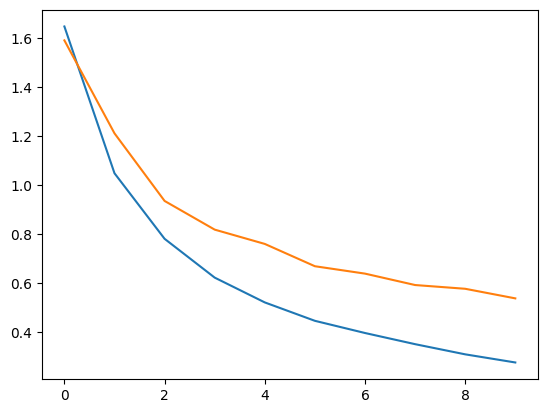

In [70]:
plt.plot(train_losses)
plt.plot(val_losses)

CUDA device count: 0
MPS available: True
Current device: mps
